In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
import joblib
import os
import time

#import fasttext

import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm
from safetensors.torch import save_file 

from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW

# Подготовка данных и EDA

In [76]:
# Загрузка данных
df = pd.read_csv("final_cleaned_balanced_dataset.csv")
df.head(15)

,text,label
0,В последние несколько лет человеческий капитал...,formal
1,В соответствии с действующей инструкцией Минис...,formal
2,если добавить в уксус соду то будет вулкан,informal
3,"Известный российский дизайнер, основатель и вл...",formal
4,ну типа плохо то что осталось супер-пупер мало...,informal
5,При Алексее Михайловиче их популярность стала ...,formal
6,когда было четыре года здесь в городе вот в се...,informal
7,потому что в поиске он не находится,informal
8,уберите этого бота он меня бесит,informal
9,зачем это тебе надо забудь вообще забей на эту...,informal


In [77]:
# Базовая информация
print("Размер датасета:", df.shape)
print(df.describe())

Размер датасета: (12994, 2)
                                                     text   label
count                                               12994   12994
unique                                              12994       2
top     В последние несколько лет человеческий капитал...  formal
freq                                                    1    6497



Пропущенные значения:
text     0
label    0
dtype: int64

Уникальные метки:
label
formal      6497
informal    6497
Name: count, dtype: int64

Дубликатов по тексту: 0


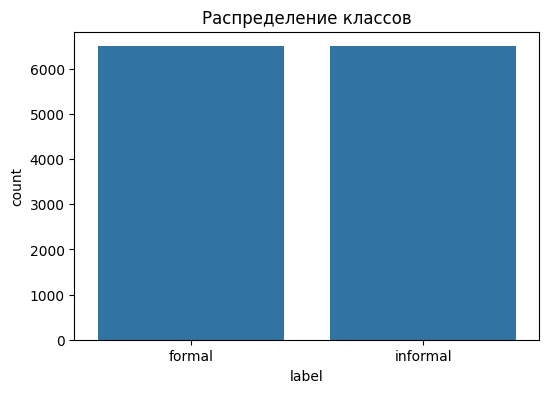

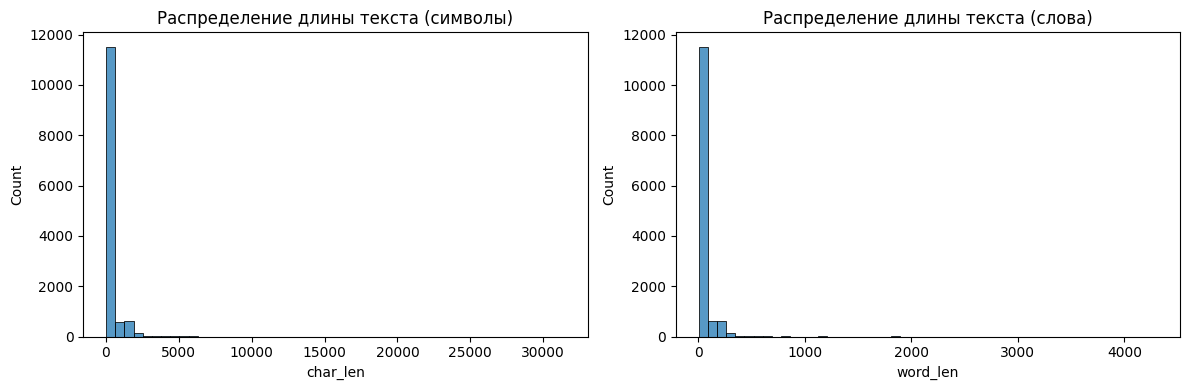

In [78]:
# Проверка на пропуски
print("\nПропущенные значения:")
print(df.isnull().sum())

# Удаление строк с пропусками
df = df.dropna().reset_index(drop=True)

# Проверка уникальных значений в label
print("\nУникальные метки:")
print(df['label'].value_counts())

# Проверка дубликатов
duplicates = df.duplicated(subset=['text']).sum()
print(f"\nДубликатов по тексту: {duplicates}")
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)

# Преобразуем метки в числа
label_map = {'informal': 0, 'formal': 1}
df['label_id'] = df['label'].map(label_map)

# Визуализация распределения классов
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Распределение классов")
plt.show()

# Длина текстов (по символам и словам)
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['char_len'], bins=50, kde=False)
plt.title("Распределение длины текста (символы)")

plt.subplot(1, 2, 2)
sns.histplot(df['word_len'], bins=50, kde=False)
plt.title("Распределение длины текста (слова)")
plt.tight_layout()
plt.show()


Текстов длиннее 512 токенов: 82 из 12994 (0.63%)


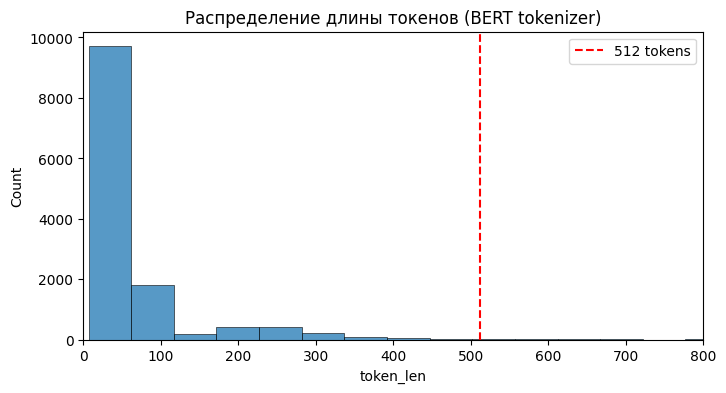

In [79]:
# Токенизация и проверка длины токенов (для BERT)
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def count_tokens(text):
    return len(tokenizer.encode(text, truncation=False))

df['token_len'] = df['text'].apply(count_tokens)

# Сколько текстов превышает 512 токенов?
over_512 = (df['token_len'] > 512).sum()
print(f"\nТекстов длиннее 512 токенов: {over_512} из {len(df)} ({over_512 / len(df) * 100:.2f}%)")

# Визуализация длины токенов
plt.figure(figsize=(8, 4))
sns.histplot(df['token_len'], bins=100, kde=False)
plt.axvline(512, color='red', linestyle='--', label='512 tokens')
plt.title("Распределение длины токенов (BERT tokenizer)")
plt.legend()
plt.xlim(0, 800)
plt.show()

In [80]:
# Разделение на train/val/test
from sklearn.model_selection import train_test_split

X = df['text'].tolist()
y = df['label_id'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 9095, Val: 1949, Test: 1950


# Обучение классификаторов

In [82]:
# Создаем папку для моделей
os.makedirs("models", exist_ok=True)

## Классические модели

### Векторизация (TF-IDF)

In [83]:
# Векторизация (TF-IDF)
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    lowercase=False
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
print(f"Размер TF-IDF матрицы: {X_train_tfidf.shape}")

Размер TF-IDF матрицы: (9095, 20000)


In [84]:
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")

['models/tfidf_vectorizer.pkl']

In [85]:
def evaluate_and_save_sklearn(model, X_test_vec, y_true, name, save_path):
    y_pred = model.predict(X_test_vec)
    y_proba = model.predict_proba(X_test_vec)[:, 1]

    # Метрики
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    # === Красивый вывод ===
    print(f"\n{'='*60}")
    print(f"Результаты модели: {name}")
    print(f"{'='*60}")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Macro F1:      {f1_macro:.4f}")
    print(f"Weighted F1:   {f1_weighted:.4f}")
    print(f"ROC-AUC:       {roc_auc:.4f}")
    print(f"PR-AUC:        {pr_auc:.4f}")

    print("\n--- Confusion Matrix ---")
    print("              Predicted")
    print("               informal   formal")
    print(f"Actual informal   {cm[0][0]:>6}   {cm[0][1]:>6}")
    print(f"       formal     {cm[1][0]:>6}   {cm[1][1]:>6}")

    print("\n--- Classification Report ---")
    target_names = ['informal', 'formal']
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Сохранение
    joblib.dump(model, save_path)

    return {
        "name": name,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }

### Логистическая регрессия

In [86]:
# Логистическая регрессия
#print("\nПодбор гиперпараметров для Logistic Regression...")
#lr_param_grid = {
#    'C': [0.1, 1.0, 10.0],
#    'penalty': ['l1', 'l2'],
#    'solver': ['liblinear', 'saga']
#}

#lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
#lr_grid = GridSearchCV(lr, lr_param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
#start_time = time.time()
#lr_grid.fit(X_train_tfidf, y_train)

#print(f"Подбор завершён за {time.time() - start_time:.2f} сек.")
#print(f"Лучшие параметры: {lr_grid.best_params_}")

#res_lr = evaluate_and_save_sklearn(lr_grid.best_estimator_, X_test_tfidf, y_test, "Logistic Regression (Optimized)", "models/lr_model.pkl")

lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
res_lr = evaluate_and_save_sklearn(lr, X_test_tfidf, y_test, "Logistic Regression", "models/lr_model.pkl")



Результаты модели: Logistic Regression
Accuracy:      0.9354
Macro F1:      0.9354
Weighted F1:   0.9354
ROC-AUC:       0.9837
PR-AUC:        0.9857

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal      896       79
       formal         47      928

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.95      0.92      0.93       975
      formal       0.92      0.95      0.94       975

    accuracy                           0.94      1950
   macro avg       0.94      0.94      0.94      1950
weighted avg       0.94      0.94      0.94      1950



### SVM

In [88]:
# SVM
#print("\nПодбор гиперпараметров для SVM...")
#svm_param_grid = {
#    'C': [0.1, 1.0, 10.0],
#    'kernel': ['rbf', 'linear'],
#    'gamma': ['scale', 'auto']
#}

#svm = SVC(class_weight='balanced', probability=True, random_state=42)
#svm_rand = RandomizedSearchCV(svm, svm_param_grid, n_iter=5, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1, random_state=42)
#start_time = time.time()
#svm_rand.fit(X_train_tfidf, y_train)

#print(f"Подбор завершён за {time.time() - start_time:.2f} сек.")
#print(f"Лучшие параметры: {svm_rand.best_params_}")

#res_svm = evaluate_and_save_sklearn(svm_rand.best_estimator_, X_test_tfidf, y_test, "SVM (Optimized)", "models/svm_model.pkl")

svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_tfidf, y_train)
res_svm = evaluate_and_save_sklearn(svm, X_test_tfidf, y_test, "SVM", "models/svm_model.pkl")


Результаты модели: SVM
Accuracy:      0.9503
Macro F1:      0.9503
Weighted F1:   0.9503
ROC-AUC:       0.9882
PR-AUC:        0.9900

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal      917       58
       formal         39      936

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.96      0.94      0.95       975
      formal       0.94      0.96      0.95       975

    accuracy                           0.95      1950
   macro avg       0.95      0.95      0.95      1950
weighted avg       0.95      0.95      0.95      1950



### Naive Bayes

In [87]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
res_nb = evaluate_and_save_sklearn(nb, X_test_tfidf, y_test, "Naive Bayes", "models/nb_model.pkl")


Результаты модели: Naive Bayes
Accuracy:      0.9256
Macro F1:      0.9256
Weighted F1:   0.9256
ROC-AUC:       0.9776
PR-AUC:        0.9818

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal      923       52
       formal         93      882

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.91      0.95      0.93       975
      formal       0.94      0.90      0.92       975

    accuracy                           0.93      1950
   macro avg       0.93      0.93      0.93      1950
weighted avg       0.93      0.93      0.93      1950



### Ансамбль

In [89]:
# Ансамбль
ensemble = VotingClassifier(
    #estimators=[('lr', lr_grid.best_estimator_), ('svm', svm_rand.best_estimator_), ('nb', nb)],
    estimators=[('lr', lr), ('svm', svm), ('nb', nb)],
    voting='soft'
)
ensemble.fit(X_train_tfidf, y_train)
res_ens = evaluate_and_save_sklearn(ensemble, X_test_tfidf, y_test, "Ensemble", "models/ensemble_model.pkl")


Результаты модели: Ensemble
Accuracy:      0.9446
Macro F1:      0.9446
Weighted F1:   0.9446
ROC-AUC:       0.9858
PR-AUC:        0.9883

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal      917       58
       formal         50      925

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.95      0.94      0.94       975
      formal       0.94      0.95      0.94       975

    accuracy                           0.94      1950
   macro avg       0.94      0.94      0.94      1950
weighted avg       0.94      0.94      0.94      1950



### FastText

In [28]:
# FastText
#fasttext_results = None

# Подготовка формата FastText
#with open("train_fasttext.txt", "w", encoding="utf-8") as f:
#        for text, label in zip(X_train, y_train):
#            ft_label = "__label__formal" if label == 1 else "__label__informal"
#            f.write(f"{ft_label} {text}\n")
#with open("test_fasttext.txt", "w", encoding="utf-8") as f:
#    for text, label in zip(X_test, y_test):
#        ft_label = "__label__formal" if label == 1 else "__label__informal"
#        f.write(f"{ft_label} {text}\n")

# Обучение
#ft_model = fasttext.train_supervised("train_fasttext.txt", epoch=25, lr=1.0, wordNgrams=2, dim=100, loss='ova')
#ft_model.save_model("models/fasttext_model.bin")

# Оценка
#y_pred_ft, y_proba_ft = [], []
#for text in X_test:
#    labels, probs = ft_model.predict(text, k=2)
#    prob_formal = dict(zip(labels, probs)).get("__label__formal", 0.0)
#    pred = 1 if prob_formal > 0.5 else 0
#    y_pred_ft.append(pred)
#    y_proba_ft.append(prob_formal)

#y_pred_ft = np.array(y_pred_ft)
#y_proba_ft = np.array(y_proba_ft)

#acc = accuracy_score(y_test, y_pred_ft)
#f1_macro = f1_score(y_test, y_pred_ft, average='macro')
#f1_weighted = f1_score(y_test, y_pred_ft, average='weighted')
#roc_auc = roc_auc_score(y_test, y_proba_ft)
#pr_auc = average_precision_score(y_test, y_proba_ft)
#cm = confusion_matrix(y_test, y_pred_ft)

#print(f"\nFastText (Test):")
#print(f"  Accuracy: {acc:.4f}")
#print(f"  Macro F1: {f1_macro:.4f}")
#print(f"  Weighted F1: {f1_weighted:.4f}")
#print(f"  ROC-AUC: {roc_auc:.4f}")
#print(f"  PR-AUC: {pr_auc:.4f}")
#print(f"  Confusion Matrix:\n{cm}")

#fasttext_results = {
#    'name': 'FastText', 'acc': acc, 'f1_macro': f1_macro,
#    'f1_weighted': f1_weighted, 'roc_auc': roc_auc, 'pr_auc': pr_auc, 'cm': cm
#}


## Нейросети  Bi-LSTM и CNN

In [90]:
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nУстройство: {device}")


Устройство: cuda


In [91]:
# Подготовка данных
def build_vocab(texts, min_freq=2):
    from collections import Counter
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [92]:
vocab = build_vocab(X_train)
MAX_LEN = 256

# Сохранение
with open('models/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [93]:
def text_to_seq(text, vocab, max_len=MAX_LEN):
    seq = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    return seq[:max_len]

In [94]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        seq = text_to_seq(self.texts[idx], self.vocab, self.max_len)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [95]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.stack(labels)

In [96]:
train_dataset = TextDataset(X_train, y_train, vocab)
val_dataset = TextDataset(X_val, y_val, vocab)
test_dataset = TextDataset(X_test, y_test, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=0)

In [97]:
# Валидация
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    return val_loss, acc, f1_macro, all_labels, all_preds

In [98]:
# Обучение с логами и графиками
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs, model_name, patience=3):
    model.to(device)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1s = []

    best_f1 = 0
    trigger_times = 0

    print(f"\nОбучение {model_name}...")
    for epoch in range(epochs):
        # Обучение
        model.train()
        total_train_loss = 0
        for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        val_loss, val_acc, val_f1, val_true, val_pred = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val Macro F1: {val_f1:.4f}")

        # Early Stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger_times = 0
            torch.save(model.state_dict(), f"models/{model_name.lower().replace(' ', '_')}_best.pth")
            joblib.dump(model.state_dict(), f"models/{model_name.lower().replace(' ', '_')}_best.pkl")
            print("Сохранена лучшая модель!")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping на эпохе {epoch+1}")
                break

    # --- Графики ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.title(f'{model_name}: Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, color='green', marker='s')
    plt.title(f'{model_name}: Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(val_f1s, color='purple', marker='^')
    plt.title(f'{model_name}: Val Macro F1')
    plt.xlabel('Epoch'); plt.ylabel('Macro F1'); plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"models/{model_name.lower().replace(' ', '_')}_training.png", dpi=150)
    plt.show()

    return train_losses, val_losses, val_accuracies, val_f1s

### Bi-LSTM

In [99]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = torch.cat([h_n[-2], h_n[-1]], dim=1)
        return self.fc(self.dropout(out))


Обучение Bi-LSTM...


Epoch 1/6 | Train Loss: 0.3889 | Val Loss: 0.1477 | Val Acc: 0.9533 | Val Macro F1: 0.9533
Сохранена лучшая модель!


Epoch 2/6 | Train Loss: 0.1244 | Val Loss: 0.1101 | Val Acc: 0.9620 | Val Macro F1: 0.9620
Сохранена лучшая модель!


Epoch 3/6 | Train Loss: 0.0785 | Val Loss: 0.0903 | Val Acc: 0.9708 | Val Macro F1: 0.9708
Сохранена лучшая модель!


Epoch 4/6 | Train Loss: 0.0530 | Val Loss: 0.0857 | Val Acc: 0.9728 | Val Macro F1: 0.9728
Сохранена лучшая модель!


Epoch 5/6 | Train Loss: 0.0407 | Val Loss: 0.0917 | Val Acc: 0.9697 | Val Macro F1: 0.9697


Epoch 6/6 | Train Loss: 0.0623 | Val Loss: 0.0925 | Val Acc: 0.9682 | Val Macro F1: 0.9682


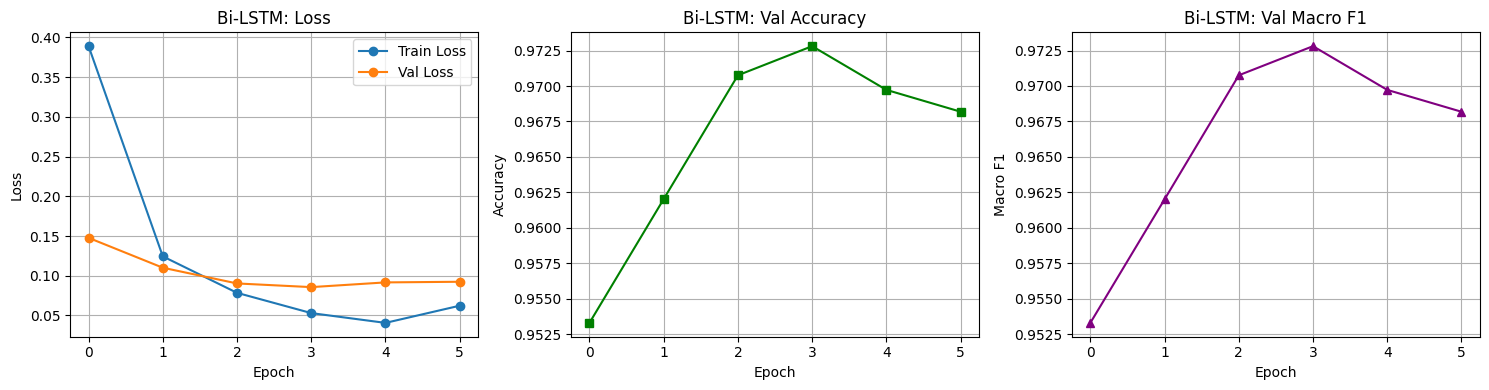

([0.388943078869081,
  0.12440847324116247,
  0.07852409924608428,
  0.053026504492243894,
  0.04070267706484228,
  0.062326111039472415],
 [0.14772303306287335,
  0.11012549518096831,
  0.09033470246339997,
  0.0857174632500016,
  0.09165295713671273,
  0.09245239775026998],
 [0.9533093894304772,
  0.9620318111852232,
  0.9707542329399692,
  0.9728065674704977,
  0.9697280656747049,
  0.9681888147768086],
 [0.953305406635693,
  0.9620115598897533,
  0.9707542329399692,
  0.9728063097511823,
  0.9697254834231417,
  0.9681857913138716])

In [100]:
bilstm = BiLSTMClassifier(len(vocab)).to(device)
optimizer_bilstm = torch.optim.Adam(bilstm.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train(
    model=bilstm,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_bilstm,
    criterion=criterion,
    device=device,
    epochs=6,
    model_name="Bi-LSTM",
    patience=3
)

### CNN

In [101]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=2, num_filters=50, filter_sizes=[3,4,5]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, fs) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        conv_outs = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(-1)).squeeze(-1) for c in conv_outs]
        x = torch.cat(pooled, dim=1)
        return self.fc(self.dropout(x))


Обучение CNN...


Epoch 1/6 | Train Loss: 0.3451 | Val Loss: 0.1583 | Val Acc: 0.9461 | Val Macro F1: 0.9461
Сохранена лучшая модель!


Epoch 2/6 | Train Loss: 0.1464 | Val Loss: 0.1238 | Val Acc: 0.9559 | Val Macro F1: 0.9559
Сохранена лучшая модель!


Epoch 3/6 | Train Loss: 0.1023 | Val Loss: 0.1096 | Val Acc: 0.9610 | Val Macro F1: 0.9610
Сохранена лучшая модель!


Epoch 4/6 | Train Loss: 0.0826 | Val Loss: 0.1037 | Val Acc: 0.9656 | Val Macro F1: 0.9656
Сохранена лучшая модель!


Epoch 5/6 | Train Loss: 0.0654 | Val Loss: 0.0995 | Val Acc: 0.9646 | Val Macro F1: 0.9646


Epoch 6/6 | Train Loss: 0.0532 | Val Loss: 0.0988 | Val Acc: 0.9636 | Val Macro F1: 0.9636


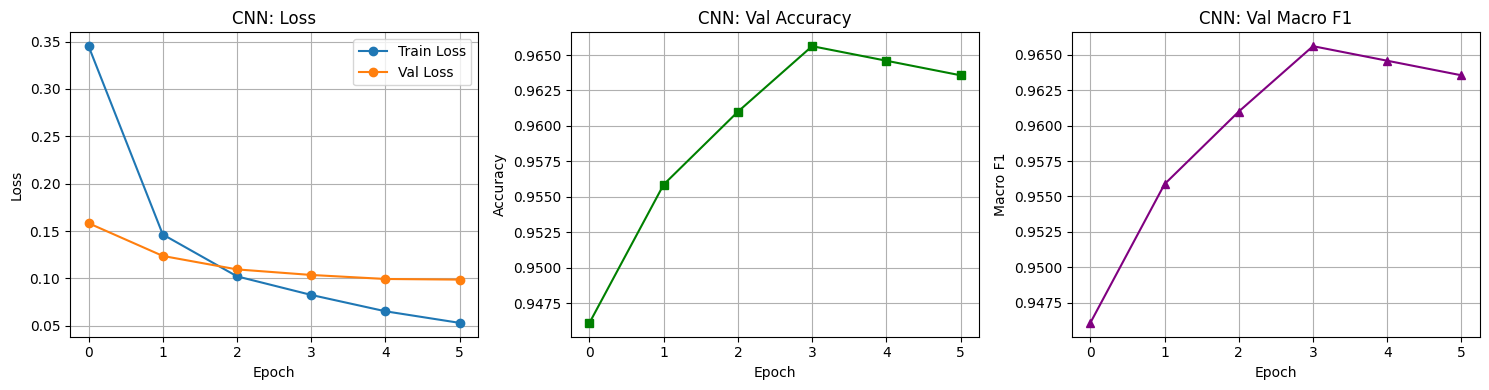

([0.3450781911403149,
  0.14640363191182798,
  0.10225549811770866,
  0.08264406812312147,
  0.06539865254287745,
  0.05316891173109204],
 [0.15832786670615595,
  0.12378396442340266,
  0.10957735031843185,
  0.10372718423604965,
  0.09948160367146615,
  0.09881562355064577],
 [0.9461262185736276,
  0.9558748075936377,
  0.9610056439199589,
  0.965623396613648,
  0.9645972293483838,
  0.9635710620831196],
 [0.9460680642139093,
  0.9558738666638587,
  0.9610019377395846,
  0.9656232518161367,
  0.9645942094270639,
  0.963564578026159])

In [102]:
cnn = CNNClassifier(len(vocab)).to(device)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train(
    model=cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_cnn,
    criterion=criterion,
    device=device,
    epochs=6,
    model_name="CNN",
    patience=3
)

In [103]:
# Оценка на тесте
def evaluate_torch_model_with_metrics(model, loader, device, model_name):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_proba = np.array(all_probs)

    # Метрики
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Вывод
    print(f"\n=== Результаты модели: {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    print("\n--- Confusion Matrix ---")
    print("          Predicted")
    print("           Informal Formal")
    print(f"Actual Informal   {cm[0][0]:>6} {cm[0][1]:>6}")
    print(f"       Formal     {cm[1][0]:>6} {cm[1][1]:>6}")

    print("\n--- Classification Report ---")
    target_names = ['informal', 'formal']
    print(classification_report(y_true, y_pred, target_names=target_names))

    return {
        "name": model_name,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }


In [104]:
# Оценка
res_bilstm = evaluate_torch_model_with_metrics(bilstm, test_loader, device, "Bi-LSTM")


=== Результаты модели: Bi-LSTM ===
Accuracy: 0.9646
Macro F1: 0.9646
Weighted F1: 0.9646
ROC-AUC: 0.9945
PR-AUC: 0.9942

--- Confusion Matrix ---
          Predicted
           Informal Formal
Actual Informal      933     42
       Formal         27    948

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.97      0.96      0.96       975
      formal       0.96      0.97      0.96       975

    accuracy                           0.96      1950
   macro avg       0.96      0.96      0.96      1950
weighted avg       0.96      0.96      0.96      1950



In [105]:
res_cnn = evaluate_torch_model_with_metrics(cnn, test_loader, device, "CNN")


=== Результаты модели: CNN ===
Accuracy: 0.9682
Macro F1: 0.9682
Weighted F1: 0.9682
ROC-AUC: 0.9959
PR-AUC: 0.9960

--- Confusion Matrix ---
          Predicted
           Informal Formal
Actual Informal      932     43
       Formal         19    956

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.98      0.96      0.97       975
      formal       0.96      0.98      0.97       975

    accuracy                           0.97      1950
   macro avg       0.97      0.97      0.97      1950
weighted avg       0.97      0.97      0.97      1950



#  Fine-tuning BERT

In [106]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [107]:
def encode_texts(texts, tokenizer, max_length=512):
    return tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

print("Кодирование текстов для BERT...")

# Train
train_enc = encode_texts(X_train, tokenizer)
train_dataset_bert = TensorDataset(
    train_enc['input_ids'], train_enc['attention_mask'],
    torch.tensor(y_train, dtype=torch.long)
)

# Val
val_enc = encode_texts(X_val, tokenizer)
val_dataset_bert = TensorDataset(
    val_enc['input_ids'], val_enc['attention_mask'],
    torch.tensor(y_val, dtype=torch.long)
)

# Test
test_enc = encode_texts(X_test, tokenizer)
test_dataset_bert = TensorDataset(
    test_enc['input_ids'], test_enc['attention_mask'],
    torch.tensor(y_test, dtype=torch.long)
)

Кодирование текстов для BERT...


In [108]:
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True, pin_memory=True, num_workers=0)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

In [109]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=2):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(self.dropout(outputs.pooler_output))

In [110]:
bert_backbone = AutoModel.from_pretrained(model_name, use_safetensors=True)
model_bert = BERTClassifier(bert_backbone).to(device)
optimizer = AdamW(model_bert.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
# Сохранение
tokenizer.save_pretrained("models/rubert_tokenizer")
bert_backbone.save_pretrained("models/rubert_backbone")

In [112]:
# Списки для графиков
train_losses = []
val_losses = []
val_f1s = []

# Вспомогательная функция валидации
def validate_bert(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, all_labels, all_preds


Fine-tuning RuBERT...


Epoch 1/2: 100%|██████████| 569/569 [02:54<00:00,  3.27it/s]


Epoch 1/2 | Train Loss: 0.0546 | Val Loss: 0.0156 | Val Macro F1: 0.9954
Сохранена лучшая модель!


Epoch 2/2: 100%|██████████| 569/569 [02:54<00:00,  3.27it/s]


Epoch 2/2 | Train Loss: 0.0086 | Val Loss: 0.0110 | Val Macro F1: 0.9969
Сохранена лучшая модель!


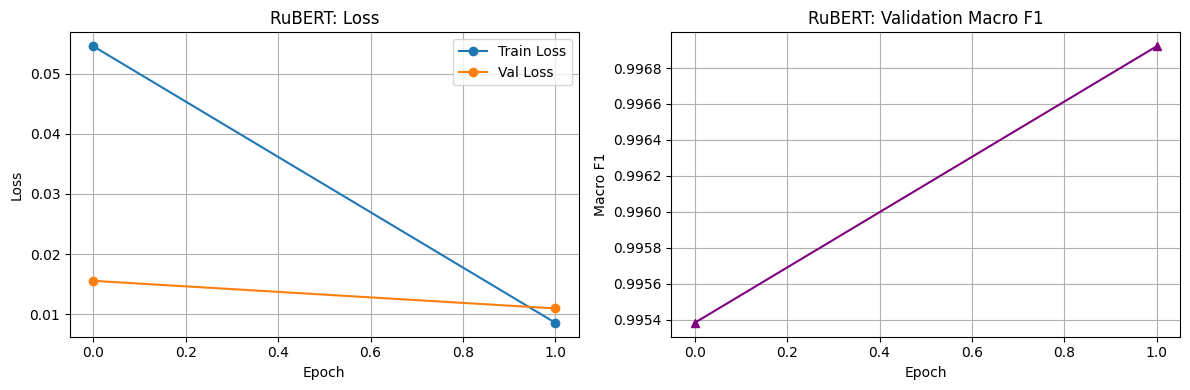

In [113]:
# Обучение с графиками
best_f1 = 0
patience = 2
trigger_times = 0
num_epochs = 2

print("\nFine-tuning RuBERT...")
for epoch in range(num_epochs):
    # Обучение
    model_bert.train()
    total_train_loss = 0
    for batch in tqdm(train_loader_bert, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids, attention_mask, labels = [b.to(device, non_blocking=True) for b in batch]
        optimizer.zero_grad()
        outputs = model_bert(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader_bert)
    train_losses.append(avg_train_loss)

    # Валидация
    val_loss, val_f1, _, _ = validate_bert(model_bert, val_loader_bert, criterion, device)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        trigger_times = 0
        torch.save(model_bert.state_dict(), "models/bert_classifier_best.pth")
        joblib.dump(model_bert.state_dict(), "models/bert_classifier_best.pkl")
        print("Сохранена лучшая модель!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

# Графики обучения для BERT
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('RuBERT: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val Macro F1', color='purple', marker='^')
plt.title('RuBERT: Validation Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.grid(True)

plt.tight_layout()
plt.savefig("models/bert_training.png", dpi=150)
plt.show()

In [114]:
def evaluate_bert_with_metrics(model, loader, device, model_name):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Передаем в модель оба тензора
            outputs = model(input_ids, attention_mask)

            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_proba = np.array(all_probs)

    # Метрики
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Вывод
    print(f"\n=== Результаты модели: {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    print("\n--- Confusion Matrix ---")
    print("          Predicted")
    print("           Informal Formal")
    print(f"Actual Informal   {cm[0][0]:>6} {cm[0][1]:>6}")
    print(f"       Formal     {cm[1][0]:>6} {cm[1][1]:>6}")

    print("\n--- Classification Report ---")
    target_names = ['informal', 'formal']
    print(classification_report(y_true, y_pred, target_names=target_names))

    return {
        "name": model_name,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }

In [115]:
# Оценка
res_bert = evaluate_bert_with_metrics(model_bert, test_loader_bert, device, "RuBERT")


=== Результаты модели: RuBERT ===
Accuracy: 0.9938
Macro F1: 0.9938
Weighted F1: 0.9938
ROC-AUC: 0.9999
PR-AUC: 0.9999

--- Confusion Matrix ---
          Predicted
           Informal Formal
Actual Informal      972      3
       Formal          9    966

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.99      1.00      0.99       975
      formal       1.00      0.99      0.99       975

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950



# Сводка и анализ

In [116]:
# Собираем все результаты
all_results = [
    res_lr,
    res_svm,
    res_nb,
    res_ens,
    res_bilstm,
    res_cnn,
    res_bert
]

In [117]:
# Сводная таблица
summary_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'cm'} for r in all_results])
print("\nСводная таблица моделей (сортировка по Macro F1):")
summary_df.sort_values('f1_macro', ascending=False).to_string(index=False)
summary_df


Сводная таблица моделей (сортировка по Macro F1):


,name,acc,f1_macro,f1_weighted,roc_auc,pr_auc
0,Logistic Regression,0.935385,0.935367,0.935367,0.983701,0.985718
1,SVM,0.950256,0.950252,0.950252,0.988216,0.989999
2,Naive Bayes,0.925641,0.925608,0.925608,0.977619,0.981846
3,Ensemble,0.944615,0.944614,0.944614,0.985755,0.988254
4,Bi-LSTM,0.964615,0.964613,0.964613,0.994454,0.994227
5,CNN,0.968205,0.968200,0.968200,0.995897,0.996035
6,RuBERT,0.993846,0.993846,0.993846,0.999871,0.999873


In [118]:
# Лучшая модель
best_model = max(all_results, key=lambda x: x['f1_macro'])
print(f"\nЛучшая модель: {best_model['name']} (Macro F1 = {best_model['f1_macro']:.4f})")


Лучшая модель: RuBERT (Macro F1 = 0.9938)


In [119]:
# Примеры ошибок (на примере RuBERT)
if best_model['name'] == 'RuBERT':
    model_bert.eval()
    errors = []
    for i, batch in enumerate(test_loader_bert):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model_bert(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
        for j in range(len(labels)):
            if preds[j] != labels[j]:
                idx = i * 16 + j
                if idx < len(X_test):
                    text = X_test[idx]
                    true_label = "formal" if labels[j].item() == 1 else "informal"
                    pred_label = "formal" if preds[j].item() == 1 else "informal"
                    errors.append((text, true_label, pred_label))
                    if len(errors) >= 3:
                        break
        if len(errors) >= 3:
            break

    print("\nПримеры ошибок RuBERT:")
    for text, true, pred in errors:
        print(f"Текст: {text}...")
        print(f"Истинный: {true} → Предсказанный: {pred}\n")


Примеры ошибок RuBERT:
Текст: Билефельд, Западная Германия Дорогой мистер Холмс, я хотел узнать, не могли бы Вы приехать ко мне в школу? Занятия начинаются в следующем месяце. Туда очень легко добраться на лодке, а обедать Вы могли бы в нашей столовой. Вы можете остановиться в моей комнате....
Истинный: formal → Предсказанный: informal

Текст: Это был комментарий к материалу Это был комментарий к материалу Это был комментарий к курсу Это был комментарий к материалу Это были комментарии к курсу Это был комментарий к материалу Это был комментарий к материалу Это был комментарий к материалу Это был комментарий к материалу Мы выдумали ответ стоматология для всей семьи ....
Истинный: formal → Предсказанный: informal

Текст: К сожалению, эта игра не работает на мобильных устройствах, воспользуйтесь компьютером...
Истинный: formal → Предсказанный: informal



# Анализ причин ошибок
Возможные причины ошибок:
* Смешанный стиль (официальный текст с разговорными вставками)
* Очень короткие тексты (<5 слов) — мало контекста
* Использование формальных конструкций в неформальном контексте (ирония, цитаты)* Тексты длиной >512 токенов (BERT обрезает их)
* Недостаток разнообразия в обучающей выборке для редких случаев
* Высокая вариативность разговорной речи (сленг, эмодзи, опечатки)

# Проверка

In [120]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, vocab=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab or {}
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        seq = [self.vocab.get(w, self.vocab.get('<UNK>', 1)) for w in self.texts[idx].split()]
        seq = seq[:self.max_len]
        if len(seq) < self.max_len:
            seq += [self.vocab['<PAD>']] * (self.max_len - len(seq))
        if self.labels is not None:
            return torch.tensor(seq, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)
        return torch.tensor(seq, dtype=torch.long)

def text_to_seq(text, vocab, max_len=256):
    seq = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    return seq[:max_len] + [vocab['<PAD>']] * max(0, max_len - len(seq))

# Загрузка моделей
def load_classical_model(path):
    return joblib.load(path)

def load_torch_model(model_class, path, **kwargs):
    model = model_class(**kwargs)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu'), weights_only=True))
    model.eval()
    return model

def load_vocab(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def load_rubert_model():
    tokenizer = AutoTokenizer.from_pretrained("models/rubert_tokenizer")
    bert_backbone = AutoModel.from_pretrained("models/rubert_backbone")
    model = BERTClassifier(bert_backbone, num_classes=2)
    model.load_state_dict(torch.load("models/bert_classifier_best.pth", map_location=torch.device('cpu'), weights_only=True))
    model.eval()
    return model, tokenizer

In [121]:
test_texts = [
    "Уважаемый клиент, благодарим за обращение в нашу компанию.",
    "Привет! Как дела? Давай встретимся сегодня вечером!",
    "В соответствии с постановлением Правительства РФ от 15.03.2023...",
    "Короче, я в шоке от этого фильма, реально зашло!",
    "Докладная записка: по факту нарушения трудовой дисциплины...",
    "Эй, чё как? Ты видел последний выпуск? Круто же!",
    "Приказываю произвести списание товарно-материальных ценностей.",
    "Ну ты и лох, как можно такое ляпнуть?))",
]

y_true = [1, 0, 1, 0, 1, 0, 1, 0]  # 1 – formal, 0 – informal

In [122]:
device = torch.device('cpu')

# Загрузка моделей  
print("Загрузка моделей...")

# Классические
lr = load_classical_model("models/lr_model.pkl")
svm = load_classical_model("models/svm_model.pkl")
nb = load_classical_model("models/nb_model.pkl")
ensemble = load_classical_model("models/ensemble_model.pkl")

# TF-IDF векторизатор
vectorizer = joblib.load("models/tfidf_vectorizer.pkl")

# Bi-LSTM / CNN
with open("models/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

bilstm = load_torch_model(BiLSTMClassifier, "models/bi-lstm_best.pth", vocab_size=len(vocab))
cnn = load_torch_model(CNNClassifier, "models/cnn_best.pth", vocab_size=len(vocab))

# RuBERT
rubert_model, rubert_tokenizer = load_rubert_model()

# Векторизация текстов
X_test_vec = vectorizer.transform(test_texts)

# DataLoader для нейросетей
def create_loader(texts, vocab, batch_size=8):
    dataset = TextDataset(texts, vocab=vocab, max_len=256)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

test_loader_lstm = create_loader(test_texts, vocab)
test_loader_cnn = create_loader(test_texts, vocab)

def predict_torch(model, loader, device):
    preds = []
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, tuple):
                x = batch[0].to(device)
            else:
                x = batch.to(device)
            out = model(x)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
    return preds

# Предсказания
print("\nПредсказания моделей:\n")
print(f"{'Текст':<60} | {'Истина'} | {'LR'} | {'SVM'} | {'NB'} | {'Ens'} | {'BiLSTM'} | {'CNN'} | {'RuBERT'}")
print("-" * 140)

lr_pred = lr.predict(X_test_vec)
svm_pred = svm.predict(X_test_vec)
nb_pred = nb.predict(X_test_vec)
ens_pred = ensemble.predict(X_test_vec)
bilstm_pred = predict_torch(bilstm, test_loader_lstm, device)
cnn_pred = predict_torch(cnn, test_loader_cnn, device)

# RuBERT
def predict_rubert(texts, model, tokenizer, device, max_len=512):
    model.eval()
    preds = []
    with torch.no_grad():
        for text in texts:
            enc = tokenizer(text, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
            input_ids = enc['input_ids'].to(device)
            attention_mask = enc['attention_mask'].to(device)
            logits = model(input_ids, attention_mask)
            pred = logits.argmax(dim=1).item()
            preds.append(pred)
    return preds

rubert_pred = predict_rubert(test_texts, rubert_model, rubert_tokenizer, device)

for i, text in enumerate(test_texts):
    short_text = (text[:57] + '...') if len(text) > 60 else text
    print(f"{short_text:<60} | {y_true[i]:>6} | {lr_pred[i]:>3} | {svm_pred[i]:>3} | {nb_pred[i]:>3} | {ens_pred[i]:>3} | {bilstm_pred[i]:>7} | {cnn_pred[i]:>3} | {rubert_pred[i]:>6}")

Загрузка моделей...

Предсказания моделей:

Текст                                                        | Истина | LR | SVM | NB | Ens | BiLSTM | CNN | RuBERT
--------------------------------------------------------------------------------------------------------------------------------------------
Уважаемый клиент, благодарим за обращение в нашу компанию.   |      1 |   0 |   0 |   0 |   0 |       0 |   0 |      1
Привет! Как дела? Давай встретимся сегодня вечером!          |      0 |   0 |   0 |   0 |   0 |       0 |   0 |      0
В соответствии с постановлением Правительства РФ от 15.03... |      1 |   1 |   1 |   1 |   1 |       0 |   1 |      1
Короче, я в шоке от этого фильма, реально зашло!             |      0 |   0 |   0 |   0 |   0 |       0 |   0 |      0
Докладная записка: по факту нарушения трудовой дисциплины... |      1 |   1 |   1 |   1 |   1 |       0 |   0 |      0
Эй, чё как? Ты видел последний выпуск? Круто же!             |      0 |   0 |   0 |   0 |   0 |       0 

# Выводы

Мы собрали единый датасет из различных датасетов, почистили тексты, добавили метки, а также сделали его сбалансированным и достаточно большим — по 6497 тысячи примеров на каждый стиль, что дало моделям отличную основу для обучения. В целом, работа с данными прошла очень успешно. Все этапы — от EDA до финальной оценки — показали, что задача классификации стиля (разговорный vs официальный) на русском языке решается неплохо. 

В общем, по результатам обучения и тестирования всех моделей для классификации текстов на разговорный (informal) и официально-деловой (formal) стили можно сказать следующее: лидирующие позиции безоговорочно заняли две трансформерные модели — RuBERT и CNN. RuBERT показала просто феноменальные метрики, особенно по Macro F1 (0.9938) и ROC AUC (0.9998), что говорит о её исключительной способности точно различать оба класса, даже если они несбалансированы. Визуально это подтверждается графиками обучения: loss устойчиво снижается, а validation Macro F1 растёт почти до идеального значения, что указывает на отсутствие переобучения и высокую обобщающую способность. CNN тоже сработала отлично, чуть уступив RuBERT по всем метрикам, но всё равно показав отличные результаты (Macro F1 0.9682). Это говорит о том, что даже относительно простые архитектуры вроде свёрточных сетей могут быть очень эффективны для задач NLP, если правильно настроить.

Среди "классических" моделей лучшей оказалась Logistic Regression, которая, хоть и уступает нейросетям, показала весьма достойный результат (Macro F1 0.9353). SVM и Naive Bayes оказались немного хуже, но всё ещё на хорошем уровне. Ансамблевая модель Ensemble, как и ожидалось, собрала в себе сильные стороны базовых алгоритмов и показала результат, близкий к линейной регрессии. Что касается Bi-LSTM, то она также показала хорошие результаты (Macro F1 0.9646), но при этом графики обучения выглядят менее стабильно: после 3-й эпохи точность и F1 начинают немного падать, что может указывать на начало переобучения или на необходимость более тонкой настройки гиперпараметров.

Анализ конкретных ошибок RuBERT показал, что модель иногда путает очень короткие или шаблонные фразы, которые могут звучать формально, но используются в неформальном контексте, например, "К сожалению, эта игра не работает на мобильных устройствах...". Также видно, что модель уверенно справляется с явно разговорными оборотами ("Ну ты и лох", "Круто же!"), но может ошибиться, если текст содержит смешанный стиль или является техническим комментарием, который формально оформлен, но по сути несет информационную нагрузку, а не деловую. В целом, для практического использования в продакшене лучше всего подойдёт RuBERT из-за её максимальной точности и надёжности, хотя для быстрого прототипирования или в условиях ограниченных ресурсов можно рассмотреть Logistic Regression или CNN.# Выводы

Мы собрали единый датасет из различных датасетов, почистили тексты, добавили метки, а также сделали его сбалансированным и достаточно большим — по 6497 тысячи примеров на каждый стиль, что дало моделям отличную основу для обучения. В целом, работа с данными прошла очень успешно. Все этапы — от EDA до финальной оценки — показали, что задача классификации стиля (разговорный vs официальный) на русском языке решается неплохо. 

В общем, по результатам обучения и тестирования всех моделей для классификации текстов на разговорный (informal) и официально-деловой (formal) стили можно сказать следующее: лидирующие позиции безоговорочно заняли две трансформерные модели — RuBERT и CNN. RuBERT показала просто феноменальные метрики, особенно по Macro F1 (0.9938) и ROC AUC (0.9998), что говорит о её исключительной способности точно различать оба класса, даже если они несбалансированы. Визуально это подтверждается графиками обучения: loss устойчиво снижается, а validation Macro F1 растёт почти до идеального значения, что указывает на отсутствие переобучения и высокую обобщающую способность. CNN тоже сработала отлично, чуть уступив RuBERT по всем метрикам, но всё равно показав отличные результаты (Macro F1 0.9682). Это говорит о том, что даже относительно простые архитектуры вроде свёрточных сетей могут быть очень эффективны для задач NLP, если правильно настроить.

Среди "классических" моделей лучшей оказалась Logistic Regression, которая, хоть и уступает нейросетям, показала весьма достойный результат (Macro F1 0.9353). SVM и Naive Bayes оказались немного хуже, но всё ещё на хорошем уровне. Ансамблевая модель Ensemble, как и ожидалось, собрала в себе сильные стороны базовых алгоритмов и показала результат, близкий к линейной регрессии. Что касается Bi-LSTM, то она также показала хорошие результаты (Macro F1 0.9646), но при этом графики обучения выглядят менее стабильно: после 3-й эпохи точность и F1 начинают немного падать, что может указывать на начало переобучения или на необходимость более тонкой настройки гиперпараметров.

Анализ конкретных ошибок RuBERT показал, что модель иногда путает очень короткие или шаблонные фразы, которые могут звучать формально, но используются в неформальном контексте, например, "К сожалению, эта игра не работает на мобильных устройствах...". Также видно, что модель уверенно справляется с явно разговорными оборотами ("Ну ты и лох", "Круто же!"), но может ошибиться, если текст содержит смешанный стиль или является техническим комментарием, который формально оформлен, но по сути несет информационную нагрузку, а не деловую. В целом, для практического использования в продакшене лучше всего подойдёт RuBERT из-за её максимальной точности и надёжности, хотя для быстрого прототипирования или в условиях ограниченных ресурсов можно рассмотреть Logistic Regression или CNN.